# 1 时间序列数据预测

## 1.1 数据集引入

In [1]:
import pandas_datareader as pdr
gs10 = pdr.get_data_fred('GS10')
gs10.head()

,GS10
DATE,
2018-02-01,2.86
2018-03-01,2.84
2018-04-01,2.87
2018-05-01,2.98
2018-06-01,2.91


## 1.2 绘制数据图像

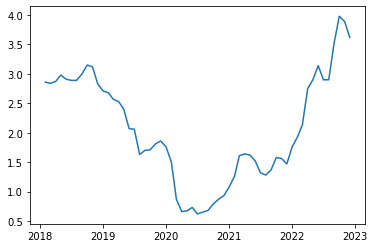

In [2]:
import matplotlib.pyplot as plt
plt.plot(gs10)
plt.show()

## 1.3 数据预处理

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)                           # 总数据量
x = torch.tensor(gs10['GS10'].to_list())  # 股价列表
seq_len = 6                               # 预测序列长度
batch_size = 4                            # 设置批大小

X_feature = torch.zeros((num - seq_len, seq_len))      # 全零初始化特征矩阵，num-seq_len行，seq_len列
for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]    # 为特征矩阵赋值
y_label = x[seq_len:].reshape((-1, 1))           # 真实结果列表

train_loader = DataLoader(TensorDataset(X_feature[:num-seq_len], 
    y_label[:num-seq_len]), batch_size=batch_size, shuffle=True)  # 构建数据加载器

In [4]:
train_loader.dataset[:batch_size]

(tensor([[2.8600, 2.8400, 2.8700, 2.9800, 2.9100, 2.8900],
         [2.8400, 2.8700, 2.9800, 2.9100, 2.8900, 2.8900],
         [2.8700, 2.9800, 2.9100, 2.8900, 2.8900, 3.0000],
         [2.9800, 2.9100, 2.8900, 2.8900, 3.0000, 3.1500]]),
 tensor([[2.8900],
         [3.0000],
         [3.1500],
         [3.1200]]))

## 1.4 构建基本神经网络模型

In [5]:
from torch import nn
from tqdm import *

class Model(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens):
        super().__init__()
        self.linear1 = nn.Linear(input_size, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, output_size)

    
    def forward(self, X):
        output = torch.relu(self.linear1(X))
        output = self.linear2(output)
        return output

# 定义超参数
input_size = seq_len
output_size = 1
num_hiddens = 10  
lr = 0.01

# 建立模型
model = Model(input_size, output_size, num_hiddens)
criterion = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr)

## 1.5 模型训练

100%|██████████| 20/20 [00:00<00:00, 130.13it/s]


Epoch 1: Validation loss = 0.7089
Epoch 2: Validation loss = 0.4812
Epoch 3: Validation loss = 0.2999
Epoch 4: Validation loss = 0.2695
Epoch 5: Validation loss = 0.2106
Epoch 6: Validation loss = 0.2270
Epoch 7: Validation loss = 0.1922
Epoch 8: Validation loss = 0.1899
Epoch 9: Validation loss = 0.1816
Epoch 10: Validation loss = 0.1578
Epoch 11: Validation loss = 0.1442
Epoch 12: Validation loss = 0.1734
Epoch 13: Validation loss = 0.1430
Epoch 14: Validation loss = 0.1842
Epoch 15: Validation loss = 0.1331
Epoch 16: Validation loss = 0.1289
Epoch 17: Validation loss = 0.1232
Epoch 18: Validation loss = 0.1135
Epoch 19: Validation loss = 0.1444
Epoch 20: Validation loss = 0.1159


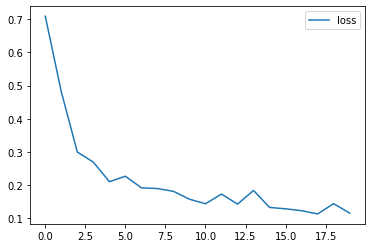

In [6]:
num_epochs = 20
loss_history = []

for epoch in tqdm(range(num_epochs)):
    # 批量训练
    for X, y in train_loader:
        trainer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.sum().backward()
        trainer.step()
    # 输出损失
    with torch.no_grad():
        total_loss = 0
        for X, y in train_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            total_loss += loss.sum()/loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
        loss_history.append(avg_loss)
    
# 绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.legend()
plt.show()

## 1.6 模型预测

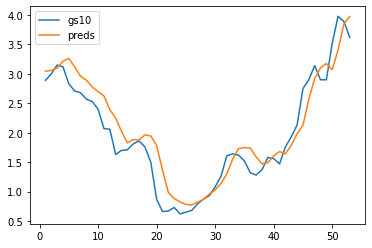

In [7]:
preds = model(X_feature)
time = torch.arange(1, num+1, dtype= torch.float32)  # 时间轴

plt.plot(time[:num-seq_len], gs10['GS10'].to_list()[seq_len:num], label='gs10')
plt.plot(time[:num-seq_len], preds.detach().numpy(), label='preds')
plt.legend()
plt.show()

# 2 RNN模型预测

## 2.1 数据预处理

一般神经网络模型结构如下：
<img src="./images/image1.png" width="30%" ></img>

循环神经网络模型结构如下：

<img src="./images/image2.png" ></img>

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)                           # 总数据量，59
x = torch.tensor(gs10['GS10'].to_list())  # 股价列表
seq_len = 6                               # 预测序列长度
batch_size = 4                            # 设置批大小

X_feature = torch.zeros((num - seq_len, seq_len))      # 构建特征矩阵，num-seq_len行，seq_len列，初始值均为0
Y_label = torch.zeros((num - seq_len, seq_len))        # 构建标签矩阵，形状同特征矩阵
for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]    # 为特征矩阵赋值
    Y_label[:, i] = x[i+1: num - seq_len + i + 1]    # 为标签矩阵赋值

train_loader = DataLoader(TensorDataset(
    X_feature[:num-seq_len].unsqueeze(2), Y_label[:num-seq_len]),
    batch_size=batch_size, shuffle=True)  # 构建数据加载器

In [9]:
train_loader.dataset[:batch_size]

(tensor([[[2.8600],
          [2.8400],
          [2.8700],
          [2.9800],
          [2.9100],
          [2.8900]],
 
         [[2.8400],
          [2.8700],
          [2.9800],
          [2.9100],
          [2.8900],
          [2.8900]],
 
         [[2.8700],
          [2.9800],
          [2.9100],
          [2.8900],
          [2.8900],
          [3.0000]],
 
         [[2.9800],
          [2.9100],
          [2.8900],
          [2.8900],
          [3.0000],
          [3.1500]]]),
 tensor([[2.8400, 2.8700, 2.9800, 2.9100, 2.8900, 2.8900],
         [2.8700, 2.9800, 2.9100, 2.8900, 2.8900, 3.0000],
         [2.9800, 2.9100, 2.8900, 2.8900, 3.0000, 3.1500],
         [2.9100, 2.8900, 2.8900, 3.0000, 3.1500, 3.1200]]))

## 2.2 构建循环神经网络模型

In [10]:
from torch import nn
from tqdm import *

class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens, n_layers):
        super(RNNModel, self).__init__()
        self.num_hiddens = num_hiddens
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, num_hiddens, n_layers, batch_first = True)
        self.linear = nn.Linear(num_hiddens, output_size)
       
    def forward(self, X):
        batch_size = X.size(0)
        state = self.begin_state(batch_size)
        output, state = self.rnn(X, state)
        output = self.linear(torch.relu(output))
        return output, state

    def begin_state(self, batch_size=1):
        return  torch.zeros(self.n_layers, batch_size, self.num_hiddens)

# 定义超参数
input_size = 1
output_size = 1
num_hiddens = 10
n_layers = 1
lr = 0.01

# 建立模型
model = RNNModel(input_size, output_size, num_hiddens, n_layers)
criterion = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr)

## 2.3 训练

 35%|███▌      | 7/20 [00:00<00:00, 62.68it/s]

Epoch 1: Validation loss = 1.2063
Epoch 2: Validation loss = 0.6640
Epoch 3: Validation loss = 0.6163
Epoch 4: Validation loss = 0.5854
Epoch 5: Validation loss = 0.4029
Epoch 6: Validation loss = 0.3159
Epoch 7: Validation loss = 0.1687
Epoch 8: Validation loss = 0.1145
Epoch 9: Validation loss = 0.0840
Epoch 10: Validation loss = 0.0751
Epoch 11: Validation loss = 0.1014
Epoch 12: Validation loss = 0.0798
Epoch 13: Validation loss = 0.0535


100%|██████████| 20/20 [00:00<00:00, 63.90it/s]

Epoch 14: Validation loss = 0.0552
Epoch 15: Validation loss = 0.0517
Epoch 16: Validation loss = 0.0510
Epoch 17: Validation loss = 0.0488
Epoch 18: Validation loss = 0.0574
Epoch 19: Validation loss = 0.0516
Epoch 20: Validation loss = 0.0457


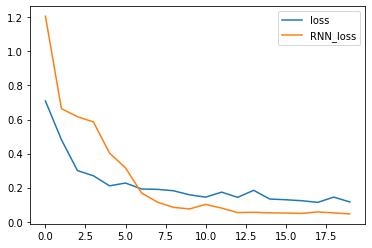

In [11]:
num_epochs = 20
rnn_loss_history = []

for epoch in tqdm(range(num_epochs)):
    # 批量训练
    for X, Y in train_loader:
        trainer.zero_grad()
        y_pred, state = model(X)
        loss = criterion(y_pred.squeeze(), Y.squeeze())
        loss.sum().backward()
        trainer.step()
    # 输出损失
    with torch.no_grad():
        total_loss = 0
        for X, Y in train_loader:
            y_pred, state = model(X)
            loss = criterion(y_pred.squeeze(), Y.squeeze())
            total_loss += loss.sum()/loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
        rnn_loss_history.append(avg_loss)
    
# 绘制损失曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(rnn_loss_history, label='RNN_loss')
plt.legend()
plt.show()

## 2.4 预测

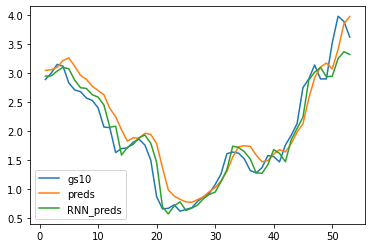

In [12]:
rnn_preds,_ = model(X_feature.unsqueeze(2))
preds.squeeze()
time = torch.arange(1, num+1, dtype= torch.float32)  # 时间轴

plt.plot(time[:num-seq_len], gs10['GS10'].to_list()[seq_len:num], label='gs10')
plt.plot(time[:num-seq_len], preds.detach().numpy(), label='preds')
plt.plot(time[:num-seq_len], rnn_preds[:,seq_len-1].detach().numpy(), label='RNN_preds')
plt.legend()
plt.show()

In [13]:
x

tensor([2.8600, 2.8400, 2.8700, 2.9800, 2.9100, 2.8900, 2.8900, 3.0000, 3.1500,
        3.1200, 2.8300, 2.7100, 2.6800, 2.5700, 2.5300, 2.4000, 2.0700, 2.0600,
        1.6300, 1.7000, 1.7100, 1.8100, 1.8600, 1.7600, 1.5000, 0.8700, 0.6600,
        0.6700, 0.7300, 0.6200, 0.6500, 0.6800, 0.7900, 0.8700, 0.9300, 1.0800,
        1.2600, 1.6100, 1.6400, 1.6200, 1.5200, 1.3200, 1.2800, 1.3700, 1.5800,
        1.5600, 1.4700, 1.7600, 1.9300, 2.1300, 2.7500, 2.9000, 3.1400, 2.9000,
        2.9000, 3.5200, 3.9800, 3.8900, 3.6200])